# 패키지 불러오기

In [30]:
import pandas as pd
pd.options.display.float_format = '{:.6f}'.format
import numpy as np

import os

import logging

# 로그 생성
logger = logging.getLogger()

# 로그의 출력 기준 설정
logger.setLevel(logging.INFO)

# log 출력 형식
formatter = logging.Formatter("%(message)s")

# Start defining and assigning your handlers here
handler = logging.StreamHandler()
handler.setFormatter(formatter)
logger.addHandler(handler)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기, 크기 확인

In [31]:
a = pd.read_csv('tmdb_5000_credits.csv')[['movie_id', 'cast', 'crew']]
b = pd.read_csv('tmdb_5000_movies.csv')
merge = a.merge(b, how='left', left_on='movie_id', right_on='id')

In [32]:
# 문자열 결측값 전처리
merge.replace('[]', np.nan, inplace=True)

In [33]:
# 결측값 비율이 높은 컬럼 (homepage, tagline) 제거
merge.drop(['homepage', 'tagline'], axis=1, inplace=True)

In [34]:
[(item[0], item[1]) for item in merge.isnull().sum().items() if item[1] != 0]

[('cast', 43),
 ('crew', 28),
 ('genres', 28),
 ('keywords', 412),
 ('overview', 3),
 ('production_companies', 351),
 ('production_countries', 174),
 ('release_date', 1),
 ('runtime', 2),
 ('spoken_languages', 86)]

In [35]:
# 컬럼 제거
merge.drop(['cast', 'crew', 'production_companies', 'production_countries', 'release_date', 'runtime', 'spoken_languages'], axis=1, inplace=True)
merge.dropna(subset=['genres'], inplace=True)

In [36]:
merge['genres'] = merge['genres'].apply(lambda x: re.findall(r'"name":\s"(.+?)"', str(x)))

# Overview 전처리

In [37]:
import re

# keywords와 overview가 모두 결측치인 행 제거
merge = merge[~(merge.keywords.isnull() & merge.overview.isnull())]
merge.reset_index(drop=True, inplace=True)


merge['keywords'] = merge['keywords'].apply(lambda x: re.findall(r'"name":\s"(.+?)"', x) if isinstance(x, str) else np.nan)
# merge['keywords'] = merge['keywords'].apply(lambda x: re.findall(r'"name":\s"(.+?)"', str(x)))
# merge['spoken_languages'] = merge['spoken_languages'].apply(lambda x: re.findall(r'"name":\s"(.+?)"', str(x)))
# merge['production_countries'] = merge['production_countries'].apply(lambda x: re.findall(r'"name":\s"(.+?)"', str(x)))
# merge['production_companies'] = merge['production_companies'].apply(lambda x: re.findall(r'"name":\s"(.+?)"', str(x)))

In [38]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

merge['overview'] = merge['overview'].apply(lambda x: re.sub(r"[^a-zA-Z0-9]", ' ', x) if isinstance(x, str) else x) # 특수문자 제거
merge['overview'] = merge['overview'].apply(lambda x: re.sub("\d+[a-zA-Z]+", ' ', x) if isinstance(x, str) else x) # (숫자 + 문자)  제거
merge['overview'] = merge['overview'].apply(lambda x: re.sub("[0-9]", '', x).strip() if isinstance(x, str) else x) # 숫자 제거

merge['overview'] = merge['overview'].apply(lambda x: word_tokenize(x) if isinstance(x, str) else x) # 토큰나이징

In [39]:
from nltk.corpus import stopwords  

def remove_stop_words(word_tokens: list) -> list:

    if not isinstance(word_tokens, list):
        return word_tokens

    stop_words = stopwords.words('english')

    result = []

    for token in word_tokens: 
        if token not in stop_words: 
            result.append(token)
            
    return result
    
# merge['overview'] =  merge['overview'].apply(lambda x: word_tokenize(x))
merge['overview'] = merge.apply(lambda x: remove_stop_words(x['overview']), axis=1)

In [40]:
merge['keywords'] = np.where(merge['keywords'].isnull(), merge['overview'], merge['keywords']) # 결측값 대체
merge.drop('overview', axis=1, inplace=True)

# EDA

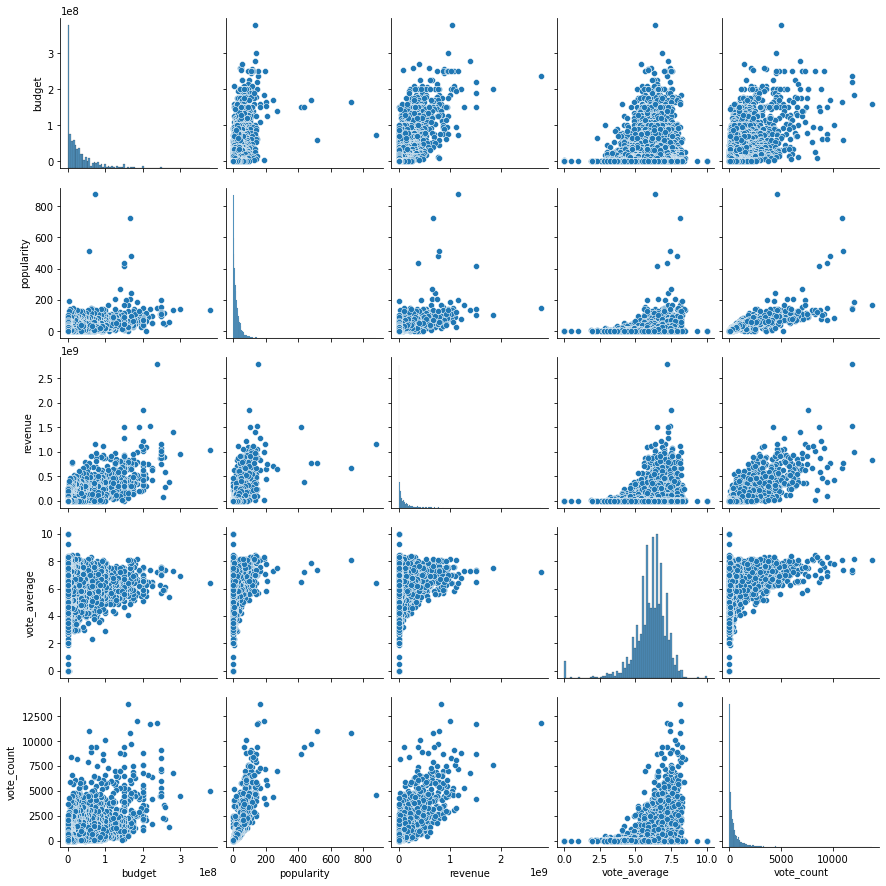

In [41]:
import seaborn as sns
sns_plot = sns.pairplot(merge[['budget', 'popularity', 'revenue', 'vote_average', 'vote_count']])
sns_plot.savefig("output.png")
# print(format(stats.pearsonr(merge[merge.release_date != ''].release_date, merge[merge.release_date != ''].vote_average)[1], 'f'))

# Contents-based Filtering

In [43]:
def join_words(lst: list) -> list:

    try:
        result = ' '.join(lst)
    except:
        result = lst
    return result

merge['keywords'] = merge.apply(lambda x : join_words(x['keywords']), axis=1)
merge['keywords']

0       culture clash future space war space colony so...
1       ocean drug abuse exotic island east india trad...
2       spy based on novel secret agent sequel mi6 bri...
3       dc comics crime fighter terrorist secret ident...
4       based on novel mars medallion space travel pri...
                              ...                        
4769    Adam security guard travels California Philipp...
4770    united states\u2013mexico barrier legs arms pa...
4771    A newlywed couple honeymoon upended arrivals r...
4772    date love at first sight narration investigati...
4773                 obsession camcorder crush dream girl
Name: keywords, Length: 4774, dtype: object

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
tfidf_vectorizer = TfidfVectorizer(min_df=2, analyzer='word', stop_words='english')
tfid_matrix = tfidf_vectorizer.fit_transform(merge['keywords'])

In [104]:
tfid_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 코사인 유사도

In [105]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_matrix = cosine_similarity(tfid_matrix, tfid_matrix)
pd.DataFrame(np.round(cosine_matrix, 4))

,0,1,2,3,4,5,6,7,8,9,...,4764,4765,4766,4767,4768,4769,4770,4771,4772,4773
0,1.000000,0.012500,0.000000,0.000000,0.226000,0.014700,0.024400,0.026300,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.027200,0.000000,0.000000,0.000000,0.021000,0.000000
1,0.012500,1.000000,0.000000,0.030600,0.000000,0.040700,0.011800,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026000,0.000000
2,0.000000,0.000000,1.000000,0.050700,0.041800,0.048000,0.017300,0.072200,0.000000,0.022100,...,0.049500,0.000000,0.000000,0.000000,0.000000,0.000000,0.094400,0.000000,0.000000,0.000000
3,0.000000,0.030600,0.050700,1.000000,0.000000,0.054800,0.025700,0.059500,0.000000,0.204500,...,0.000000,0.000000,0.000000,0.000000,0.080300,0.018800,0.000000,0.000000,0.000000,0.000000
4,0.226000,0.000000,0.041800,0.000000,1.000000,0.000000,0.044500,0.043300,0.000000,0.013400,...,0.030000,0.000000,0.000000,0.000000,0.030500,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4769,0.000000,0.000000,0.000000,0.018800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008400,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
4770,0.000000,0.000000,0.094400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4771,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4772,0.021000,0.026000,0.000000,0.000000,0.000000,0.030400,0.000000,0.075400,0.000000,0.000000,...,0.058800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [106]:
title_idx_arr = pd.Series(range(0, len(merge)), index=merge.title)
idx = title_idx_arr["Pirates of the Caribbean: At World's End"]

In [107]:
sim_scores = [ (title_idx_arr[i], similarity) for i, similarity in enumerate(cosine_matrix[idx]) if i != idx]
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = dict(sim_scores[:10])

In [110]:
title_idx_arr[sim_scores.keys()]

title
Pirates of the Caribbean: Dead Man's Chest                  12
Pirates of the Caribbean: The Curse of the Black Pearl     199
Anna and the King                                          536
Cutthroat Island                                           340
Nim's Island                                              1331
Swept Away                                                3097
Shipwrecked                                               3215
Pirates of the Caribbean: On Stranger Tides                 17
Sahara                                                     167
Half Baked                                                3255
dtype: int64